# Importiere Daten


In [1]:
import numpy as np
import pandas as pd
#import geopandas as gp
import xarray as xr
import datetime
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import bootstrap
import os as os

## Funktionen definieren

In [2]:
def linear_reg(x, m, t):
    return m*x + t

def generate_cosine_weight(angles):
    temp = np.cos(np.radians(angles))
    cosine_values = temp/np.sum(temp)
    return cosine_values

# def weigth(arr):
#     return np.multiply(generate_cosine_weight(arr['lat'].values), arr)

In [3]:
def weighting_arr(arr):
    lat = arr['lat']
    element_temp = ~np.isnan(arr.isel(time=0))
    ones_array = xr.ones_like(element_temp, dtype = float)
    cos_array_temp = ones_array * np.cos(np.radians(lat[:]))
    cos_array = cos_array_temp.where(element_temp)
    return cos_array

def weighting(arr, lat_min, lat_max, lon_min = -180, lon_max = 180):
    weight_arr = weighting_arr(arr).sel(lat = slice(lat_min, lat_max), lon = slice(lon_min, lon_max))
    temp =arr.sel(lat = slice(lat_min, lat_max), lon = slice(lon_min, lon_max))*weight_arr
    return temp.sum(dim= ['lat', 'lon'])/weight_arr.sum()

In [4]:
month_label = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]

legend_colors = plt.cm.tab20(range(12))

In [5]:
custom_rc_params_small = {
    'figure.figsize': (8.5, 5),  # Width x Height in centimeters
    'font.size': 12,  # Font size
    # You can add more custom parameters here if needed
}

plt.rcParams.update(custom_rc_params_small)

## Daten importieren

In [6]:
TMin_file = 'C:/Users/leonh/Desktop/Praktikum_AWI/data/cru_ts4.07.1901.2022.tmn.dat.nc/cru_ts4.07.1901.2022.tmn.dat.nc'
TMax_file = 'C:/Users/leonh/Desktop/Praktikum_AWI/data/cru_ts4.07.1901.2022.tmx.dat.nc/cru_ts4.07.1901.2022.tmx.dat.nc'
TAvg_file = 'C:/Users/leonh/Desktop/Praktikum_AWI/data/cru_ts4.07.1901.2022.tmp.dat.nc/cru_ts4.07.1901.2022.tmp.dat.nc'



TMin = xr.open_dataset(TMin_file)
TMax = xr.open_dataset(TMax_file)
TAvg = xr.open_dataset(TAvg_file)

## Daten aufbereiten und Filtern

In [7]:
mask_start = pd.to_datetime('1972')
mask_end = pd.to_datetime('2000')
mask_temp = (TMax.sel(time = slice(mask_start, mask_end)).stn > 0)
mask = mask_temp.all(dim=['time'])
del mask_temp

In [8]:

# Filtering DTR and TAvg
TMax = TMax.where(mask)
TMin = TMin.where(mask)
TAvg = TAvg.where(mask)

## Differenz berechnen

In [9]:
time_values = TMax['time'].values

In [10]:
# TMin

In [11]:
# # TMin_Lat_temp = TMin_Lat.tmn*cosine_values * weight_fac 
# # TMax_Lat_temp = TMax_Lat.tmx*cosine_values * weight_fac
# # TAvg_Lat_temp = TAvg_Lat.tmp*cosine_values * weight_fac

# TMin_Lat_temp = TMin_Lat*cosine_values * weight_fac 
# TMax_Lat_temp = TMax_Lat*cosine_values * weight_fac
# TAvg_Lat_temp = TAvg_Lat*cosine_values * weight_fac

In [12]:
TMin_Lat_tot = weighting(TMin, lat_min= -90, lat_max= 0)
TMax_Lat_tot = weighting(TMax, lat_min= -90, lat_max= 0)
TAvg_Lat_tot = weighting(TAvg, lat_min= -90, lat_max= 0)

In [13]:
# TMin_Lat_tot = TMin_Lat.mean('lat')
# TMax_Lat_tot = TMax_Lat.mean('lat')
# TAvg_Lat_tot = TAvg_Lat.mean('lat')

In [14]:
#temperature_difference = TMax - TMin   # Normale Differenz fü jeden Punkt
#temperature_difference_Lat = TMax_Lat.tmx- TMin_Lat.tmn # Creating lateral difference
temperature_difference_Pol = TMax_Lat_tot.tmx- TMin_Lat_tot.tmn

In [15]:
temperature_difference_Pol

<xarray.DataArray (time: 1464)>
array([11.84880683, 11.25523343, 11.30574715, ..., 12.87705836,
       12.32539289, 12.00631564])
Coordinates:
  * time     (time) datetime64[ns] 1901-01-16 1901-02-15 ... 2022-12-16

In [16]:
monthly_mean_DTR = temperature_difference_Pol.resample(time='M').mean()
monthly_mean_TAvg = TAvg_Lat_tot.tmp.resample(time='M').mean()


In [17]:

monthly_mean_DTR['month'] = monthly_mean_DTR['time'].dt.month
monthly_mean_TAvg['month'] = monthly_mean_TAvg['time'].dt.month

In [18]:
monthly_mean_DTR

<xarray.DataArray (time: 1464)>
array([11.84880683, 11.25523343, 11.30574715, ..., 12.87705836,
       12.32539289, 12.00631564])
Coordinates:
  * time     (time) datetime64[ns] 1901-01-31 1901-02-28 ... 2022-12-31
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

## Generiere Unterteilungen des Nordpols (Ringe)

In [19]:
# # Creating dict with different averages
# TAvg_mean_dict = {}

# slices = [(66, 70), (70, 75), (75, 80), (80, 84)]

# # Perform the slicing and calculation for each slice
# for start, end in slices:
#     # Perform the slice and calculate the mean along the 'lat' dimension
#     sliced_data = TAvg_Lat.tmp.sel(lat=slice(start, end)).mean('lat')
#     TAvg_mean_dict[f'{start}-{end}'] = sliced_data

# # Creating dict with different averages
# DTR_mean_dict = {}

# slices = [(66, 70), (70, 75), (75, 80), (80, 84)]

# # Perform the slicing and calculation for each slice
# for start, end in slices:
#     # Perform the slice and calculate the mean along the 'lat' dimension
#     sliced_data = temperature_difference_Lat.sel(lat=slice(start, end)).mean('lat')
#     DTR_mean_dict[f'{start}-{end}'] = sliced_data


Plotten

In [20]:
# Extract the keys and values from TAvg_mean_dict and DTR_mean_dict
# ta_keys = list(TAvg_mean_dict.keys())

# legend_handles = []

# for i in ta_keys:
#     plt.scatter(TAvg_mean_dict[i], DTR_mean_dict[i], label = i + '°N' )

# plt.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left')

# plt.xlabel('Average temperature [°C]')
# plt.ylabel('Diurnal temperature range [°C]')


# # plt.savefig('Bilder/DTR_latex/DTR_yearlyMean_diffrentLat_TAvg_scatter.pdf')
# # plt.savefig('Bilder/DTR_latex/DTR_yearlyMean_diffrentLat_TAvg_scatter.png')
# plt.legend()

# plt.tight_layout()
# plt.show()


## Plots Yearly trends

In [21]:
yearly_mean_TAvg = TAvg_Lat_tot.tmp.resample(time='Y').mean()

In [22]:

# # Create a figure and axis object
# fig, ax = plt.subplots(figsize=(17 / 2.54, 4))  # Adjust the figsize as needed

# # Plot the data with a line style and add labels
# ax.plot(yearly_mean_TAvg.time, yearly_mean_TAvg, marker='x', linestyle='',  color='black', label='Yearly Mean')

# # Add labels and title
# ax.set_xlabel('Years')
# ax.set_ylabel('Average Temperature [°C]')
# #ax.set_title('Diurnal Temperature Range Over Time')
# # Remove the top and right spines
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)
# # Add gridlines
# #ax.grid(True)

# # Add a legend
# #ax.legend()

# # Rotate the x-axis labels for better readability (optional)
# plt.xticks(rotation=45)

# plt.xlim(pd.to_datetime('1960',))
# # Show the plot
# plt.tight_layout()  # Ensures that labels fit within the figure
# plt.show()



In [23]:
# yearly_mean_DTR = temperature_difference_Pol.resample(time='Y').mean()

In [24]:

# # Create a figure and axis object
# fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the figsize as needed

# # Plot the data with a line style and add labels
# ax.plot(yearly_mean_DTR.time, yearly_mean_DTR, marker='x', linestyle='',  color='r', label='Yearly Mean')

# # Add labels and title
# ax.set_xlabel('Years')
# ax.set_ylabel('Diurnal Temperature Range [°C]')
# #ax.set_title('Diurnal Temperature Range Over Time')

# # Add gridlines
# ax.grid(True)

# # Add a legend
# ax.legend()

# # Rotate the x-axis labels for better readability (optional)
# plt.xticks(rotation=45)

# plt.xlim(pd.to_datetime('1940',))
# # Show the plot
# plt.tight_layout()  # Ensures that labels fit within the figure

# # plt.savefig('Bilder/DTR_latex/DTR_yearlyMean_years.pdf')
# # plt.savefig('Bilder/DTR_latex/DTR_yearlyMean_years.png')
# plt.show()



In [25]:
# # Create a figure and axis object
# fig, ax = plt.subplots(figsize=(17 / 2.54, 4))  # Adjust the figsize as needed

# # Plot the data with a line style and add labels
# ax.plot(yearly_mean_TAvg.time, yearly_mean_TAvg, marker='x', linestyle='',  color='black', label='Yearly Mean')
# ax.plot(yearly_mean_DTR.time, yearly_mean_DTR, marker='x', linestyle='',  color='r', label='Yearly Mean')
# # Add labels and title
# ax.set_xlabel('Years')
# ax.set_ylabel('Temperature [°C]')
# #ax.set_title('Diurnal Temperature Range Over Time')
# # Remove the top and right spines
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
# ax.spines['left'].set_visible(False)
# # Add gridlines
# #ax.grid(True)

# # Add a legend
# #ax.legend()

# # Rotate the x-axis labels for better readability (optional)
# plt.xticks(rotation=45)

# plt.xlim(pd.to_datetime('1960',))
# # Show the plot
# plt.tight_layout()  # Ensures that labels fit within the figure
# plt.show()


In [26]:
# import matplotlib.pyplot as plt
# import pandas as pd

# # Create a figure and axis object
# fig, ax1 = plt.subplots(figsize=(17 / 2.54, 4))  # Adjust the figsize as needed

# # Plot the data with the first y-axis
# ax1.plot(yearly_mean_TAvg.time, yearly_mean_TAvg, marker='x', linestyle='',  color='black', label='Average Temperature')
# ax1.set_xlabel('Years')
# ax1.set_ylabel('Average Temperature [°C]', color='black')

# # Create a second y-axis and plot data with it
# ax2 = ax1.twinx()
# ax2.plot(yearly_mean_DTR.time, yearly_mean_DTR, marker='.', linestyle='',  color='red', label='DTR')
# ax2.set_ylabel('Diurnal Temperature Range [°C]', color='r')


# ax1.spines['top'].set_visible(False)
# ax1.spines['right'].set_visible(False)
# ax1.spines['bottom'].set_visible(False)
# ax1.spines['left'].set_visible(False)

# ax2.spines['top'].set_visible(False)
# # ax2.spines['right'].set_visible(False)
# # ax2.spines['bottom'].set_visible(False)
# # ax2.spines['left'].set_visible(False)

# plt.xlim(pd.to_datetime('1970',))
# ax2.set_ylim(7.15,7.6)

# # Add a legend
# lines1, labels1 = ax1.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
# ax2.legend(lines1 + lines2, labels1 + labels2, loc='best')

# # Show the plot
# plt.tight_layout() 
# plt.show()


In [27]:
# yearly_mean_DTR = temperature_difference_Pol.resample(time='Y').mean()

# # Create a figure and axis object
# fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the figsize as needed

# # Plot the data with a line style and add labels
# ax.scatter(yearly_mean_TAvg, yearly_mean_DTR, marker='x',  color='r') #, label='Yearly Mean')

# # Add labels and title
# ax.set_xlabel('T Average')
# ax.set_ylabel('Diurnal Temperature Range [°C]')
# #ax.set_title('Diurnal Temperature Range Over Time')

# # Add gridlines
# ax.grid(True)

# # Add a legend
# ax.legend()

# # Rotate the x-axis labels for better readability (optional)
# plt.xticks(rotation=45)

# #plt.xlim(pd.to_datetime('1940',))
# # Show the plot
# plt.tight_layout()  # Ensures that labels fit within the figure

# # plt.savefig('Bilder/DTR_latex/DTR_yearlyMean_years.pdf')
# # plt.savefig('Bilder/DTR_latex/DTR_yearlyMean_years.png')
# plt.show()



## Monthly trends

In [28]:
# # monthly_mean_TAvg = TAvg_Lat_tot.tmp.resample(time='M').mean()

# # Create a figure and axis object
# fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the figsize as needed

# # Plot the data with a line style and add labels
# ax.plot(monthly_mean_TAvg.time, monthly_mean_TAvg, marker='x', linestyle='',  color='r', label='Yearly Mean')

# # Add labels and title
# ax.set_xlabel('Years')
# ax.set_ylabel('Average Temperature [°C]')
# #ax.set_title('Diurnal Temperature Range Over Time')

# # Add gridlines
# ax.grid(True)

# # Add a legend
# ax.legend()

# # Rotate the x-axis labels for better readability (optional)
# plt.xticks(rotation=45)

# plt.xlim(pd.to_datetime('1960',))
# # Show the plot
# plt.tight_layout()  # Ensures that labels fit within the figure
# plt.show()



In [29]:
monthly_mean_DTR = temperature_difference_Pol.resample(time='M').mean()

In [30]:

# print(monthly_mean_DTR)
# # Create a figure and axis object
# fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the figsize as needed

# # Plot the data with a line style and add labels
# ax.plot(monthly_mean_DTR.time, monthly_mean_DTR, marker='x', linestyle='',  color='r', label='Yearly Mean')

# # Add labels and title
# ax.set_xlabel('Years')
# ax.set_ylabel('Diurnal Temperature Range [°C]')
# #ax.set_title('Diurnal Temperature Range Over Time')

# # Add gridlines
# ax.grid(True)

# # Add a legend
# ax.legend()

# # Rotate the x-axis labels for better readability (optional)
# plt.xticks(rotation=45)

# plt.xlim(pd.to_datetime('1960',))
# # Show the plot
# plt.tight_layout()  # Ensures that labels fit within the figure
# plt.show()



In [31]:
monthly_mean_DTR

<xarray.DataArray (time: 1464)>
array([11.84880683, 11.25523343, 11.30574715, ..., 12.87705836,
       12.32539289, 12.00631564])
Coordinates:
  * time     (time) datetime64[ns] 1901-01-31 1901-02-28 ... 2022-12-31

In [32]:
monthly_mean_DTR_dict = {}

for i in range(1, 13):
    # Slice the DataArray for the current month
    month_data = monthly_mean_DTR.where(monthly_mean_DTR['time'].dt.month == i, drop=True)
    
    # Add the sliced DataArray to the dictionary with the month as the key
    monthly_mean_DTR_dict[i] = month_data

monthly_mean_TAvg_dict = {}

for i in range(1, 13):
    # Slice the DataArray for the current month
    month_data = monthly_mean_TAvg.where(monthly_mean_TAvg['time'].dt.month == i, drop=True)
    
    # Add the sliced DataArray to the dictionary with the month as the key
    monthly_mean_TAvg_dict[i] = month_data

monthly_mean_TMin_dict = {}

for i in range(1, 13):
    # Slice the DataArray for the current month
    month_data = TMin_Lat_tot.where(TMin_Lat_tot['time'].dt.month == i, drop=True)
    
    # Add the sliced DataArray to the dictionary with the month as the key
    monthly_mean_TMin_dict[i] = month_data

monthly_mean_TMax_dict = {}

for i in range(1, 13):
    # Slice the DataArray for the current month
    month_data = TMax_Lat_tot.where(TMax_Lat_tot['time'].dt.month == i, drop=True)
    
    # Add the sliced DataArray to the dictionary with the month as the key
    monthly_mean_TMax_dict[i] = month_data

In [33]:


# # Create an empty list to store legend handles for custom legend
# legend_handles = []

# for i in range(1, 13):
#     color = legend_colors[i - 1]
#     plt.scatter(monthly_mean_TAvg_dict[i], monthly_mean_DTR_dict[i], marker='.', color=color, label='Month: ' + str(i))
#     # Create a dummy scatter plot with no markers to represent the legend
#     legend_handles.append(plt.scatter([], [], marker='.', color=color, label='Month: ' + str(i)))

# # Plot legend outside the plot
# plt.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left')

# plt.xlabel('Average temperature [°C]')
# plt.ylabel('Diurnal temperature range [°C]')


# # plt.savefig('Bilder/DTR_latex/DTR_yearlyMean_TAvg_scatter.pdf')
# # plt.savefig('Bilder/DTR_latex/DTR_yearlyMean_TAvg_scatter.png')

# plt.show()



In [34]:
# monthly_mean_TAvg = monthly_mean_TAvg.rename('TAvg')

# monthly_mean_DTR = monthly_mean_DTR.rename('DTR')
# df_merged = xr.merge([monthly_mean_DTR, monthly_mean_TAvg])


In [35]:
# monthly_mean_TAvg = monthly_mean_TAvg.rename('TAvg')
# monthly_mean_DTR = monthly_mean_DTR.rename('DTR')


# # Merge the DataArrays into a Dataset
# df_merged = xr.merge([monthly_mean_DTR, monthly_mean_TAvg])
# df_merged['DTR']

In [36]:
# d = 0.5

# # Create bins for the 'TAvg' values
# df_merged['bin'] = (np.floor(df_merged['TAvg'] / d) * d).astype(np.float32)

# # Calculate the mean of 'DTR' values in each bin
# means_da = df_merged.groupby('bin').mean(dim='time')['DTR']

# # Plot the results
# means_da.plot(marker='x', linestyle='', color='red')
# plt.xlabel('TAvg_bin')
# plt.ylabel('Mean DTR')
# plt.show()

In [37]:
# # Create bins for the 'TAvg' values
# df_merged['bin'] = np.floor(df_merged['TAvg'] / d) * d
# # Calculate the means of 'DTR' values in each bin
# means_df = df_merged.groupby('bin').mean(dim='time')

## Monthly Trends with Fit

In [38]:
# legend_colors = [plt.cm.tab20(i) for i in np.linspace(0, 1, 12)]
# legend_colors = plt.cm.tab20(range(12))

# # Create an empty list to store legend handles for custom legend
# legend_handles = []

# for i in range(1, 13):
#     color = legend_colors[i - 1]
#     plt.scatter(monthly_mean_DTR_dict[i]['time'], monthly_mean_DTR_dict[i], marker='x', color=color, label='Month: ' + str(i))
#     # Create a dummy scatter plot with no markers to represent the legend
#     legend_handles.append(plt.scatter([], [], marker='.', color=color, label='Month: ' + str(i)))

# # Plot legend outside the plot
# plt.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left')

# plt.xlabel('Average temperature [°C]')
# plt.ylabel('Diurnal temperature range [°C]')

# plt.xlim(pd.to_datetime('1960',))

# # plt.savefig('Bilder/DTR_latex/DTR_yearlyMean_TAvg_scatter.pdf')
# # plt.savefig('Bilder/DTR_latex/DTR_yearlyMean_TAvg_scatter.png')

# plt.show()




In [39]:


# # Create a list of legend colors
# legend_colors = plt.cm.tab20(range(12))

# # Create an empty list to store legend handles for custom legend
legend_handles = []

# for i in range(1, 13):
#     color = legend_colors[i - 1]
#     # Filter the data for the specified date range (1960-01-01 to 1980-12-31)
#     mask = (monthly_mean_DTR_dict[i]['time'] >= pd.to_datetime('1960-01-01')) & (monthly_mean_DTR_dict[i]['time'] <= pd.to_datetime('1980-01-01'))
#     plt.scatter(monthly_mean_DTR_dict[i]['time'][mask], monthly_mean_DTR_dict[i][mask], marker='x', color=color, label='Month: ' + str(i))
#     # Create a dummy scatter plot with no markers to represent the legend
#     legend_handles.append(plt.scatter([], [], marker='.', color=color, label='Month: ' + str(i)))

# # Plot legend outside the plot
# plt.legend(handles=legend_handles, bbox_to_anchor=(1.05, 1), loc='upper left')

# plt.xlabel('Time')
# plt.ylabel('Diurnal temperature range [°C]')

# # Set x-axis limits to the specified date range
# plt.xlim(pd.to_datetime('1960-01-01'), pd.to_datetime('1980-12-31'))

# plt.show()


In [40]:
# # Create lists to store regression coefficients and R-squared values
# regression_coeffs = []
# r_squared_values = []

# startdate = pd.to_datetime('1972-01-01')
# enddate = pd.to_datetime('2023-01-01') 

# for i in range(1,13):
#     color = legend_colors[i - 1]
#     # Filter the data for the specified date range (1960-01-01 to 1980-12-31)
#     mask = (monthly_mean_DTR_dict[i]['time'] >= startdate) & (monthly_mean_DTR_dict[i]['time'] <= enddate)
    
#     x = np.arange(len(monthly_mean_DTR_dict[i].sel(time=slice(startdate, enddate))))  # Use an index as x values
#     y = monthly_mean_DTR_dict[i].sel(time=slice(startdate, enddate))
#     print(y)

#     # Fit a linear regression line
#     slope, intercept = np.polyfit(x, y, 1)
    
#     # Calculate R-squared
#     residuals = y - (slope * x + intercept)
#     ss_res = np.sum(residuals**2)
#     ss_tot = np.sum((y - np.mean(y))**2)
#     r_squared = 1 - (ss_res / ss_tot)

#     # Plot the scatter plot
#     # plt.scatter(monthly_mean_DTR_dict[i]['time'][mask], y, marker='x', color=color, label= month_label[i-1])
    
#     # Plot the regression line
#     # plt.plot(monthly_mean_DTR_dict[i]['time'][mask], slope * x + intercept, color=color, linestyle='--') #, label='Regression Line')

#     # Create a dummy scatter plot with no markers to represent the legend
#     # legend_handles.append(plt.scatter([], [], marker='.', color=color)) #, label='Month: ' + str(i)))

#     # Append regression coefficients and R-squared values to lists
#     regression_coeffs.append((slope, intercept))
#     r_squared_values.append(r_squared)

# # # Show the legend
# # plt.legend(handles=legend_handles, labels=month_label, loc='upper left', bbox_to_anchor=(1, 1))
# # plt.xlabel('Time')
# # plt.ylabel('DTR Value')
# # plt.title('Linear Regression for ' + str(startdate.year) +' to ' + str(enddate.year))
# # plt.show()



# # # Print regression coefficients and R-squared values
# # for i, (slope, intercept) in enumerate(regression_coeffs):
# #     print(f'Month {i+1}:')
# #     print(f'  Slope (Coefficient): {slope}')
# #     print(f'  Intercept: {intercept}')
# #     print(f'  R-squared Value: {r_squared_values[i]}')

# slopes = [slope for slope, _ in regression_coeffs]
# r_squared_values = np.array(r_squared_values)  # Convert to numpy array for easier manipulation

# # # Create a figure and a set of subplots
# # fig, ax1 = plt.subplots(figsize = (17/ 2.54, 12/ 2.54))

# # # Create x-values for the bars
# # x = np.arange(len(slopes))

# # # Plot the slopes as bars on the primary y-axis
# # ax1.bar(x, slopes, width=0.4, color='b', alpha=0.7, label='Slope (Coefficient)')
# # ax1.set_xlabel('Month')
# # ax1.set_ylabel('Lin. Reg. Slope DTR/year')
# # ax1.set_ylim(min(slopes) - 0.003, max(slopes) + 0.003)

# # # Rotate the x-axis tick labels
# # ax1.set_xticks(x)
# # ax1.set_xticklabels([month_label[i] for i in range(len(slopes))], rotation=45)  # Rotate the labels here
# # ax1.legend(loc='upper left')

# # # Create a secondary y-axis for R-squared values on the right
# # ax2 = ax1.twinx()
# # ax2.plot(x, r_squared_values, 'r*-',ls = '', label='R-squared Value')
# # ax2.set_ylabel('R-squared Value')
# # ax2.set_ylim(0, 1)
# # ax2.legend(loc='upper right')

# # # Show the plot
# # # plt.title('Regression Coefficients ' + str(startdate.year) +' to ' + str(enddate.year))
# # plt.tight_layout()

# # #plt.savefig('DTR_R2_'+ str(startdate.year) +'_' + str(enddate.year)+'.pdf')
# # plt.show()


In [41]:


# # Create lists to store legend handles
# legend_handles = []

# # Create lists to store regression coefficients and R-squared values
# regression_coeffs = []
# r_squared_values = []

# startdate = pd.to_datetime('1973-01-01')
# enddate = pd.to_datetime('2023-01-01')

# for i in range(1, 13):
#     color = legend_colors[i - 1]
#     # Filter the data for the specified date range (1960-01-01 to 1980-12-31)
#     mask = (monthly_mean_TAvg_dict[i]['time'] >= startdate) & (monthly_mean_TAvg_dict[i]['time'] <= enddate)
    
#     x = np.arange(len(monthly_mean_TAvg_dict[i]['time'][mask]))  # Use an index as x values
#     y = monthly_mean_TAvg_dict[i][mask]

#     # Fit a linear regression line
#     slope, intercept = np.polyfit(x, y, 1)
    
#     # Calculate R-squared
#     residuals = y - (slope * x + intercept)
#     ss_res = np.sum(residuals**2)
#     ss_tot = np.sum((y - np.mean(y))**2)
#     r_squared = 1 - (ss_res / ss_tot)

#     # Plot the scatter plot
#     # plt.scatter(monthly_mean_TAvg_dict[i]['time'][mask], y, marker='x', color=color, label= month_label[i-1])
    
#     # # Plot the regression line
#     # plt.plot(monthly_mean_TAvg_dict[i]['time'][mask], slope * x + intercept, color=color, linestyle='--', alpha  = 0.5)

#     # # Create a dummy scatter plot with no markers to represent the legend
#     # legend_handles.append(plt.scatter([], [], marker='.', color=color))

#     # Append regression coefficients and R-squared values to lists
#     regression_coeffs.append((slope, intercept))
#     r_squared_values.append(r_squared)

# # # Show the legend outside the plot
# # plt.legend(handles=legend_handles, labels=month_label, loc='upper left', bbox_to_anchor=(1, 1))
# # plt.xlabel('Time')
# # plt.ylabel('Mean Temperature')
# # plt.title('Linear Regression for ' + str(startdate.year) +' to ' + str(enddate.year))

# # # Adjust the plot layout to accommodate the legend
# # plt.subplots_adjust(right=0.75)

# # plt.show()

# # # Print regression coefficients and R-squared values
# # for i, (slope, intercept) in enumerate(regression_coeffs):
# #     print(f'Month {i+1}:')
# #     print(f'  Slope (Coefficient): {slope}')
# #     print(f'  Intercept: {intercept}')
# #     print(f'  R-squared Value: {r_squared_values[i]}')


# slopes = [slope for slope, _ in regression_coeffs]
# r_squared_values = np.array(r_squared_values)  # Convert to numpy array for easier manipulation

# # Create a figure and a set of subplots
# # fig, ax1 = plt.subplots()

# # # Create x-values for the bars
# # x = np.arange(len(slopes))

# # # Plot the slopes as bars on the primary y-axis
# # ax1.bar(x, slopes, width=0.4, color='b', alpha=0.7, label='Slope (Coefficient)')
# # ax1.set_xlabel('Month')
# # ax1.set_ylabel('Lin. Reg. Slope TAvg/year')
# # ax1.set_ylim(min(slopes) - 0.02, max(slopes) + 0.02)

# # # Rotate the x-axis tick labels
# # ax1.set_xticks(x)
# # ax1.set_xticklabels([month_label[i] for i in range(len(slopes))], rotation=45)  # Rotate the labels here
# # ax1.grid(ls = '--')
# # ax1.legend(loc='upper left')

# # # Create a secondary y-axis for R-squared values on the right
# # ax2 = ax1.twinx()
# # ax2.plot(x, r_squared_values, 'r*-', label='R-squared Value')
# # ax2.set_ylabel('R-squared Value')
# # ax2.set_ylim(0, 1)
# # ax2.legend(loc='upper right')

# # # plt.title('Regression Coefficients ' + str(startdate.year) +' to ' + str(enddate.year))
# # plt.tight_layout()

# # #plt.savefig('TMean_R2_'+ str(startdate.year) +'_' + str(enddate.year)+'.png', dpi = 300)
# # plt.show()


## TMin TMax

In [42]:
#monthly_mean_TMax_dict

In [43]:
# Create lists to store regression coefficients and R-squared values
regression_coeffs = []
r_squared_values = []

startdate = pd.to_datetime('1972-01-01')
enddate = pd.to_datetime('2023-01-01') 

for i in range(1,13):
    color = legend_colors[i - 1]
    # Filter the data for the specified date range (1960-01-01 to 1980-12-31)
    mask = (monthly_mean_TMax_dict[i]['time'] >= startdate) & (monthly_mean_TMax_dict[i]['time'] <= enddate)
    
    # x = np.arange(len(monthly_mean_TMax_dict[i]['time'][mask]))  # Use an index as x values
    # y = monthly_mean_TMax_dict[i][mask]

    x = np.arange(len(monthly_mean_TMax_dict[i].tmx.sel(time=slice(startdate, enddate))))  # Use an index as x values
    y = monthly_mean_TMax_dict[i].tmx.sel(time=slice(startdate, enddate))

    print(y)
    # Fit a linear regression line
    slope, intercept = np.polyfit(x, y, 1)
    
    # Calculate R-squared
    residuals = y - (slope * x + intercept)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    r_squared = 1 - (ss_res / ss_tot)

    # Plot the scatter plot
    #plt.scatter(monthly_mean_TMax_dict[i]['time'][mask], y, marker='x', color=color, label= month_label[i-1])
    
    # Plot the regression line
    #plt.plot(monthly_mean_TMax_dict[i]['time'][mask], slope * x + intercept, color=color, linestyle='--') #, label='Regression Line')

    # Create a dummy scatter plot with no markers to represent the legend
    #legend_handles.append(plt.scatter([], [], marker='.', color=color)) #, label='Month: ' + str(i)))

    # Append regression coefficients and R-squared values to lists
    regression_coeffs.append((slope, intercept))
    r_squared_values.append(r_squared)

# Show the legend
# plt.legend(handles=legend_handles, labels=month_label, loc='upper left', bbox_to_anchor=(1, 1))
# plt.xlabel('Time')
# plt.ylabel('DTR Value')
# plt.title('Linear Regression for ' + str(startdate.year) +' to ' + str(enddate.year))
# plt.show()



# # Print regression coefficients and R-squared values
# for i, (slope, intercept) in enumerate(regression_coeffs):
#     print(f'Month {i+1}:')
#     print(f'  Slope (Coefficient): {slope}')
#     print(f'  Intercept: {intercept}')
#     print(f'  R-squared Value: {r_squared_values[i]}')

slopes = [slope for slope, _ in regression_coeffs]
r_squared_values = np.array(r_squared_values)  # Convert to numpy array for easier manipulation

# Create a figure and a set of subplots
# fig, ax1 = plt.subplots(figsize = (17/ 2.54, 12/ 2.54))

# Create x-values for the bars
x = np.arange(len(slopes))

slopes_TMax = slopes.copy()
# # Plot the slopes as bars on the primary y-axis
# ax1.bar(x, slopes, width=0.4, color='b', alpha=0.7, label='Slope (Coefficient)')
# ax1.set_xlabel('Month')
# ax1.set_ylabel('Lin. Reg. Slope DTR/year')
# ax1.set_ylim(min(slopes) - 0.01, max(slopes) + 0.01)

# # Rotate the x-axis tick labels
# ax1.set_xticks(x)
# ax1.set_xticklabels([month_label[i] for i in range(len(slopes))], rotation=45)  # Rotate the labels here
# ax1.legend(loc='upper left')

# # Create a secondary y-axis for R-squared values on the right
# ax2 = ax1.twinx()
# ax2.plot(x, r_squared_values, 'r*-',ls = '', label='R-squared Value')
# ax2.set_ylabel('R-squared Value')
# ax2.set_ylim(0, 1)
# ax2.legend(loc='upper right')

# # Show the plot
# # plt.title('Regression Coefficients ' + str(startdate.year) +' to ' + str(enddate.year))
# plt.tight_layout()

# #plt.savefig('DTR_R2_'+ str(startdate.year) +'_' + str(enddate.year)+'.pdf')
# plt.show()


<xarray.DataArray 'tmx' (time: 51)>
array([30.29985613, 31.37608491, 29.60539882, 30.40560184, 29.58691814,
       30.61397189, 30.2786965 , 30.82594831, 30.84383973, 30.42800355,
       30.78915183, 31.29995514, 30.25133932, 30.96670218, 30.85693385,
       30.97215287, 31.56824965, 30.58776151, 31.05460214, 30.62146136,
       30.9949056 , 30.97002086, 31.04296533, 30.99251671, 30.84063927,
       30.4540047 , 31.12038487, 31.04351641, 30.286894  , 31.13162305,
       30.77956526, 31.37071264, 31.1158323 , 31.33297283, 31.28770778,
       30.70757617, 30.90862584, 31.05301164, 31.25019591, 30.81151126,
       31.03099607, 31.72645474, 31.44284261, 31.15626198, 31.33253409,
       31.25169269, 31.47039507, 31.91354178, 31.48810325, 30.9285965 ,
       31.45667216])
Coordinates:
  * time     (time) datetime64[ns] 1972-01-16 1973-01-16 ... 2022-01-16
<xarray.DataArray 'tmx' (time: 51)>
array([30.01089622, 30.40937224, 29.14675803, 29.86222039, 29.31570633,
       30.22162999, 30.3492284

In [44]:
monthly_mean_TMin_dict[1]

<xarray.Dataset>
Dimensions:  (time: 122)
Coordinates:
  * time     (time) datetime64[ns] 1901-01-16 1902-01-16 ... 2022-01-16
Data variables:
    tmn      (time) float64 18.82 18.81 18.86 18.37 ... 20.17 20.16 19.65 20.04
    stn      (time) float64 1.382 1.497 1.468 1.403 ... 5.517 5.515 5.134 5.109

In [45]:
# Create lists to store regression coefficients and R-squared values
regression_coeffs = []
r_squared_values = []

startdate = pd.to_datetime('1972-01-01')
enddate = pd.to_datetime('2023-01-01') 

for i in range(1,13):
    color = legend_colors[i - 1]
    # Filter the data for the specified date range (1960-01-01 to 1980-12-31)
    mask = (monthly_mean_TMin_dict[i]['time'] >= startdate) & (monthly_mean_TMin_dict[i]['time'] <= enddate)
    
    # x = np.arange(len(monthly_mean_TMin_dict[i]['time'][mask]))  # Use an index as x values
    # y = monthly_mean_TMin_dict[i][mask]

    #x = np.arange(len(monthly_mean_TMin_dict[i].sel(time=slice(startdate, enddate)))) #tmx.sel(time=slice(startdate, enddate))))  # Use an index as x values
    y = monthly_mean_TMin_dict[i].tmn.sel(time=slice(startdate, enddate))
    x = np.arange(len(y))
    # Fit a linear regression line
    slope, intercept = np.polyfit(x, y, 1)
    
    # Calculate R-squared
    residuals = y - (slope * x + intercept)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    r_squared = 1 - (ss_res / ss_tot)

    # Plot the scatter plot
    #plt.scatter(monthly_mean_TMax_dict[i]['time'][mask], y, marker='x', color=color, label= month_label[i-1])
    
    # Plot the regression line
    #plt.plot(monthly_mean_TMax_dict[i]['time'][mask], slope * x + intercept, color=color, linestyle='--') #, label='Regression Line')

    # Create a dummy scatter plot with no markers to represent the legend
    #legend_handles.append(plt.scatter([], [], marker='.', color=color)) #, label='Month: ' + str(i)))

    # Append regression coefficients and R-squared values to lists
    regression_coeffs.append((slope, intercept))
    r_squared_values.append(r_squared)

# Show the legend
# plt.legend(handles=legend_handles, labels=month_label, loc='upper left', bbox_to_anchor=(1, 1))
# plt.xlabel('Time')
# plt.ylabel('DTR Value')
# plt.title('Linear Regression for ' + str(startdate.year) +' to ' + str(enddate.year))
# plt.show()



# # Print regression coefficients and R-squared values
# for i, (slope, intercept) in enumerate(regression_coeffs):
#     print(f'Month {i+1}:')
#     print(f'  Slope (Coefficient): {slope}')
#     print(f'  Intercept: {intercept}')
#     print(f'  R-squared Value: {r_squared_values[i]}')

slopes = [slope for slope, _ in regression_coeffs]
r_squared_values = np.array(r_squared_values)  # Convert to numpy array for easier manipulation

# # Create a figure and a set of subplots
# fig, ax1 = plt.subplots(figsize = (17/ 2.54, 12/ 2.54))

# Create x-values for the bars
x = np.arange(len(slopes))

slopes_TMin = slopes.copy()
# # Plot the slopes as bars on the primary y-axis
# ax1.bar(x, slopes, width=0.4, color='b', alpha=0.7, label='Slope (Coefficient)')
# ax1.set_xlabel('Month')
# ax1.set_ylabel('Lin. Reg. Slope DTR/year')
# ax1.set_ylim(min(slopes) - 0.01, max(slopes) + 0.01)

# # Rotate the x-axis tick labels
# ax1.set_xticks(x)
# ax1.set_xticklabels([month_label[i] for i in range(len(slopes))], rotation=45)  # Rotate the labels here
# ax1.legend(loc='upper left')

# # Create a secondary y-axis for R-squared values on the right
# ax2 = ax1.twinx()
# ax2.plot(x, r_squared_values, 'r*-',ls = '', label='R-squared Value')
# ax2.set_ylabel('R-squared Value')
# ax2.set_ylim(0, 1)
# ax2.legend(loc='upper right')

# # Show the plot
# # plt.title('Regression Coefficients ' + str(startdate.year) +' to ' + str(enddate.year))
# plt.tight_layout()

# plt.savefig('DTR_R2_'+ str(startdate.year) +'_' + str(enddate.year)+'.pdf')
# plt.show()


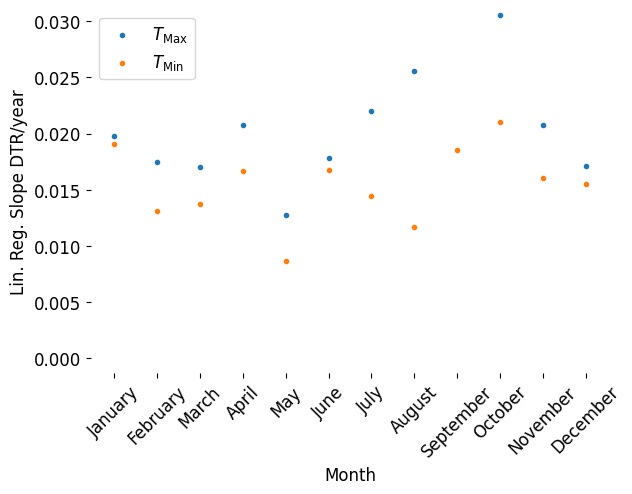

In [46]:
# Create a figure and a set of subplots
fig, ax1 = plt.subplots(figsize = (17/ 2.54, 12/ 2.54))

# Create x-values for the bars
x = np.arange(len(slopes_TMax))


# Plot the slopes as bars on the primary y-axis
ax1.scatter(x, slopes_TMax, marker='.', label='$T_{\mathrm{Max}}$')
ax1.scatter(x, slopes_TMin, marker='.', label='$T_{\mathrm{Min}}$')


ax1.set_xlabel('Month')
ax1.set_ylabel('Lin. Reg. Slope DTR/year')
ax1.set_ylim(min(slopes) - 0.01, max(slopes) + 0.01)

# Rotate the x-axis tick labels
ax1.set_xticks(x)
ax1.set_xticklabels([month_label[i] for i in range(len(slopes))], rotation=45)  # Rotate the labels here
ax1.legend(loc='upper left')

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)


# # Create a secondary y-axis for R-squared values on the right
# ax2 = ax1.twinx()
# ax2.plot(x, r_squared_values, 'r*-',ls = '', label='R-squared Value')
# ax2.set_ylabel('R-squared Value')
# ax2.set_ylim(0, 1)
# ax2.legend(loc='upper right')

# # Show the plot
# # plt.title('Regression Coefficients ' + str(startdate.year) +' to ' + str(enddate.year))
# plt.tight_layout()

# plt.savefig('DTR_R2_'+ str(startdate.year) +'_' + str(enddate.year)+'.pdf')
# plt.show()

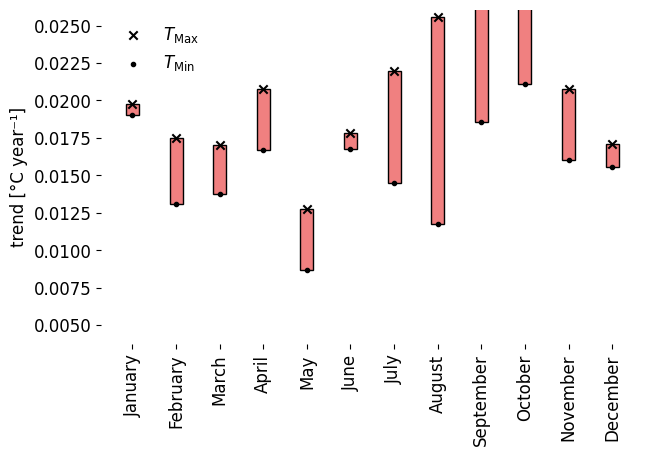

In [47]:
import numpy as np
import matplotlib.pyplot as plt

# Your existing code here

# Calculate the width of the boxes
box_width = 0.3  # Adjust this value to control the width of the boxes

fig, ax1 = plt.subplots(figsize = (17/ 2.54, 12/ 2.54))

# for i in range(len(slopes_TMax)):
#     ax1.add_patch(plt.Rectangle((x[i] - box_width / 2, slopes_TMin[i]), box_width, slopes_TMax[i] - slopes_TMin[i], fill=True, edgecolor='black', facecolor='lightgray'))
for i in range(len(slopes_TMax)):
    if slopes_TMin[i] > slopes_TMax[i]:
        facecolor = 'lightblue'
    else:
        facecolor = 'lightcoral'
    
    ax1.add_patch(plt.Rectangle((x[i] - box_width / 2, slopes_TMin[i]), box_width, slopes_TMax[i] - slopes_TMin[i], fill=True, edgecolor='black', facecolor=facecolor))


# Create x-values for the bars
x = np.arange(len(slopes_TMax))


# Plot the slopes as bars on the primary y-axis
ax1.scatter(x, slopes_TMax, marker='x',color = 'black', label='$T_{\mathrm{Max}}$')
ax1.scatter(x, slopes_TMin, marker='.',color = 'black', label='$T_{\mathrm{Min}}$')


#ax1.set_xlabel('Month')
# ax1.set_ylabel('Linear Regression Slope [°C/year]')
# ax1.set_ylabel('trend [°C year^-1]')

ax1.set_ylabel('trend [°C year\u207B\u00B9]')
ax1.set_ylim(min(slopes) - 0.005, max(slopes) + 0.005)

# Rotate the x-axis tick labels
ax1.set_xticks(x)
ax1.set_xticklabels([month_label[i] for i in range(len(slopes))], rotation=90)  # Rotate the labels here
ax1.legend(loc='upper left',frameon = False)

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)

plt.tight_layout()

plt.savefig('Monthly_Trends19722022_noPValue_subset.pdf')
# Show the plot
plt.show()



## Bootstrapping


In [48]:
# # Create lists to store regression coefficients and R-squared values
# regression_coeffs = []
# r_squared_values = []

# df_significance1973 = pd.DataFrame(columns= ['Month', 'Slope', 'PValue'])

# startdate = pd.to_datetime('1973-01-01')
# enddate = pd.to_datetime('2023-01-01') 


# for i in range(1,13):
#     color = legend_colors[i - 1]
#     # Filter the data for the specified date range (1960-01-01 to 1980-12-31)
#     mask = (monthly_mean_DTR_dict[i]['time'] >= startdate) & (monthly_mean_DTR_dict[i]['time'] <= enddate)

#     x = np.arange(len(monthly_mean_DTR_dict[i]['time'][mask]))  # Use an index as x values
#     y = monthly_mean_DTR_dict[i][mask]

#     # Fit a linear regression line
#     slope, intercept = np.polyfit(x, y, 1)

#     # Calculate R-squared
#     residuals = y - (slope * x + intercept)
#     ss_res = np.sum(residuals**2)
#     ss_tot = np.sum((y - np.mean(y))**2)
#     r_squared = 1 - (ss_res / ss_tot)

#     # Plot the scatter plot
#     plt.scatter(monthly_mean_DTR_dict[i]['time'][mask], y, marker='x', color=color, label= month_label[i-1])

#     # Plot the regression line
#     plt.plot(monthly_mean_DTR_dict[i]['time'][mask], slope * x + intercept, color=color, linestyle='--') #, label='Regression Line')

#     # Create a dummy scatter plot with no markers to represent the legend
#     legend_handles.append(plt.scatter([], [], marker='.', color=color)) #, label='Month: ' + str(i)))

#     # Append regression coefficients and R-squared values to lists
#     regression_coeffs.append((slope, intercept))
#     r_squared_values.append(r_squared)

#     # Show the legend
#     plt.legend(handles=legend_handles, labels=month_label, loc='upper left', bbox_to_anchor=(1, 1))
#     plt.xlabel('Time')
#     plt.ylabel('DTR Value')
#     plt.title('Linear Regression for ' + str(startdate.year) +' to ' + str(enddate.year))
#     plt.show()

#     print(slope)

#     #print(bootstrap(y, np.polyfit(x,y,1)[0]))



#     # Define the number of bootstrap samples
#     n_bootstrap_samples = 1000  # You can adjust this number

#     # Initialize an array to store the bootstrapped parameter estimates
#     bootstrapped_coefs = np.zeros(n_bootstrap_samples)

#     observed_coef = np.polyfit(x, y, 1)[0]
#     # Perform bootstrapping
#     for j in range(n_bootstrap_samples):
#         # Resample with replacement from the data
#         resampled_indices = np.random.choice(len(y), len(y), replace=True)
#         resampled_y = y[resampled_indices]
        
#         # Compute the parameter of interest (in this case, the coefficient of the linear regression)
#         coef = np.polyfit(x, resampled_y, 1)[0]
        
#         # Store the bootstrapped coefficient
#         bootstrapped_coefs[j] = coef

#     # Calculate the confidence interval
#     confidence_interval = np.percentile(bootstrapped_coefs, [10, 90])

#     # Print the confidence interval
#     #print("Bootstrap Confidence Interval for Coefficient:", confidence_interval)

#     p_value = (np.abs(bootstrapped_coefs) >= np.abs(observed_coef)).mean()

#     data_dict = {
#         'Month': i,
#         'Slope': observed_coef,
#         'PValue': p_value  # Initialize PValue, you'll calculate it later
#     }

#     # Append the dictionary to the DataFrame
#     df_significance1973 = df_significance1973.append(data_dict, ignore_index=True)

#     # Print the p-value
#     print("Bootstrapped p-value:", p_value)

In [49]:
# # Create lists to store regression coefficients and R-squared values
# regression_coeffs = []
# r_squared_values = []

# df_significance1973 = pd.DataFrame(columns= ['Month', 'Slope', 'PValue'])

# startdate = pd.to_datetime('1973-01-01')
# enddate = pd.to_datetime('2023-01-01') 


# for i in range(1,13):
#     color = legend_colors[i - 1]
#     # Filter the data for the specified date range (1960-01-01 to 1980-12-31)
#     mask = (monthly_mean_DTR_dict[i]['time'] >= startdate) & (monthly_mean_DTR_dict[i]['time'] <= enddate)

#     x = np.arange(len(monthly_mean_DTR_dict[i]['time'][mask]))  # Use an index as x values
#     y = monthly_mean_DTR_dict[i][mask]


#     # Define the number of bootstrap samples
#     n_bootstrap_samples = 1000  # You can adjust this number

#     # Initialize an array to store the bootstrapped parameter estimates
#     bootstrapped_coefs = np.zeros(n_bootstrap_samples)

#     observed_coef = np.polyfit(x, y, 1)[0]
#     # Perform bootstrapping
#     for j in range(n_bootstrap_samples):
#         # Resample with replacement from the data
#         resampled_indices = np.random.choice(len(y), len(y), replace=True)
#         resampled_y = y[resampled_indices]
        
#         # Compute the parameter of interest (in this case, the coefficient of the linear regression)
#         coef = np.polyfit(x, resampled_y, 1)[0]
        
#         # Store the bootstrapped coefficient
#         bootstrapped_coefs[j] = coef

#     # Calculate the confidence interval
#     confidence_interval = np.percentile(bootstrapped_coefs, [10, 90])

#     # Print the confidence interval
#     #print("Bootstrap Confidence Interval for Coefficient:", confidence_interval)

#     p_value = (np.abs(bootstrapped_coefs) >= np.abs(observed_coef)).mean()

#     data_dict = {
#         'Month': i,
#         'Slope': observed_coef,
#         'PValue': p_value  # Initialize PValue, you'll calculate it later
#     }
#     data_df = pd.DataFrame(data_dict, index=[0])
#     # Append the dictionary to the DataFrame
#     df_significance1973 = pd.concat([df_significance1973, data_df], ignore_index=True)
#     # Print the p-value
#     print("Bootstrapped p-value:", p_value)

In [50]:
monthly_mean_DTR_dict[1]

<xarray.DataArray (time: 122)>
array([11.84880683, 11.66670789, 11.7777204 , 11.62906492, 11.73771318,
       11.74950773, 11.63853195, 11.8025559 , 11.61501237, 11.68660695,
       11.60793011, 11.93736488, 11.72118816, 11.70127597, 11.56719625,
       11.73434159, 11.46057282, 11.30888668, 11.84642579, 11.52360283,
       11.66446142, 11.87538478, 11.75747852, 11.86162915, 11.3787193 ,
       11.8372749 , 11.82549868, 11.84989766, 11.84267439, 11.72703904,
       11.81592867, 12.08070554, 11.79837509, 11.66591333, 11.70461597,
       11.59468144, 11.51153684, 11.64577768, 11.63439088, 11.75625409,
       11.27874275, 11.73787089, 11.99759211, 11.98179531, 11.8100154 ,
       11.48487805, 11.94627133, 11.81136948, 11.89570889, 11.66204358,
       11.40401346, 11.78396366, 11.43997806, 11.49178001, 11.46367425,
       11.73399579, 11.74317044, 11.52185432, 11.56785704, 11.70644879,
       11.90877385, 11.42526697, 11.32465769, 11.8277409 , 12.07892261,
       11.51975526, 11.7424581 , 11.9845957 , 12.15748837, 11.95345116,
       11.64576293, 11.66294368, 11.55238693, 10.51411851, 11.89342988,
       11.00091466, 11.43512822, 11.01727106, 11.47768951, 11.7144801 ,
       10.91216802, 11.42230448, 11.69376093, 11.20944061, 11.74674086,
       11.57027399, 11.54633781, 11.79710123, 11.40391205, 11.55034922,
       11.06647064, 11.83835181, 11.4396118 , 11.63134502, 11.34037871,
       11.46212041, 11.04860084, 11.20045746, 11.32981408, 11.15291054,
       11.55341711, 11.60276476, 11.57512587, 11.30528014, 11.61141009,
       11.18982747, 11.10661399, 11.17130175, 11.57474271, 11.41876889,
       11.15595822, 11.56396389, 11.80593493, 11.6317305 , 11.50212997,
       11.04293292, 11.25590258, 11.64997204, 11.74720864, 11.33116492,
       11.27386237, 11.4198525 ])
Coordinates:
  * time     (time) datetime64[ns] 1901-01-31 1902-01-31 ... 2022-01-31

In [51]:
# Create lists to store regression coefficients and R-squared values
regression_coeffs = []
r_squared_values = []

df_significance1972 = pd.DataFrame(columns= ['Month', 'Slope', 'PValue'])

startdate = pd.to_datetime('1972-01-01')
enddate = pd.to_datetime('2023-01-01') 


for i in range(1,13):
    color = legend_colors[i - 1]
    # Filter the data for the specified date range (1960-01-01 to 1980-12-31)
    # mask = (monthly_mean_DTR_dict[i]['time'] >= startdate) & (monthly_mean_DTR_dict[i]['time'] <= enddate)

    # x = np.arange(len(monthly_mean_DTR_dict[i]['time'][mask]))  # Use an index as x values
    # y = monthly_mean_DTR_dict[i][mask]

    y = monthly_mean_DTR_dict[i].sel(time=slice(startdate, enddate))
    x = np.arange(len(y))

    # Define the number of bootstrap samples
    n_bootstrap_samples = 1000  # You can adjust this number

    # Initialize an array to store the bootstrapped parameter estimates
    bootstrapped_coefs = np.zeros(n_bootstrap_samples)

    observed_coef = np.polyfit(x, y, 1)[0]
    # Perform bootstrapping
    for j in range(n_bootstrap_samples):
        # Resample with replacement from the data
        resampled_indices = np.random.choice(len(y), len(y), replace=True)
        resampled_y = y[resampled_indices]
        
        # Compute the parameter of interest (in this case, the coefficient of the linear regression)
        coef = np.polyfit(x, resampled_y, 1)[0]
        
        # Store the bootstrapped coefficient
        bootstrapped_coefs[j] = coef

    # Calculate the confidence interval
    confidence_interval = np.percentile(bootstrapped_coefs, [10, 90])

    # Print the confidence interval
    #print("Bootstrap Confidence Interval for Coefficient:", confidence_interval)

    p_value = (np.abs(bootstrapped_coefs) >= np.abs(observed_coef)).mean()

    data_dict = {
        'Month': i,
        'Slope': observed_coef,
        'PValue': p_value  # Initialize PValue, you'll calculate it later
    }
    data_df = pd.DataFrame(data_dict, index=[0])
    # Append the dictionary to the DataFrame
    df_significance1972 = pd.concat([df_significance1972, data_df], ignore_index=True)
    # Print the p-value
    print("Bootstrapped p-value:", p_value)

C:\Users\leonh\AppData\Local\Temp\ipykernel_33720\3488250353.py:56: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_significance1972 = pd.concat([df_significance1972, data_df], ignore_index=True)


Bootstrapped p-value: 0.77
Bootstrapped p-value: 0.152
Bootstrapped p-value: 0.254
Bootstrapped p-value: 0.263
Bootstrapped p-value: 0.18
Bootstrapped p-value: 0.688
Bootstrapped p-value: 0.033
Bootstrapped p-value: 0.0
Bootstrapped p-value: 0.0
Bootstrapped p-value: 0.0
Bootstrapped p-value: 0.052
Bootstrapped p-value: 0.457


In [52]:
df_significance1972

,Month,Slope,PValue
0,1,0.000745,0.770
1,2,0.004357,0.152
2,3,0.003265,0.254
3,4,0.004076,0.263
4,5,0.004043,0.180
5,6,0.001067,0.688
6,7,0.007529,0.033
7,8,0.013854,0.000
8,9,0.014939,0.000
9,10,0.009480,0.000


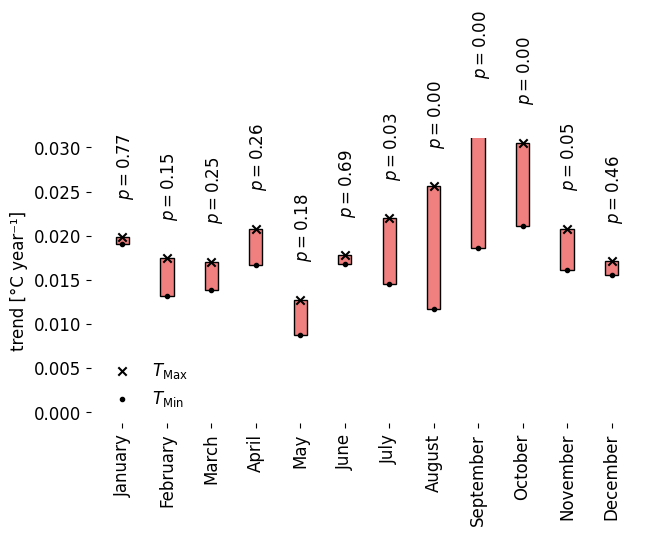

In [53]:

# Create x-values for the bars
x = np.arange(len(slopes_TMax))

# Calculate the width of the boxes
box_width = 0.3  # Adjust this value to control the width of the boxes

fig, ax1 = plt.subplots(figsize = (17/ 2.54, 15/ 2.54))

# for i in range(len(slopes_TMax)):
#     ax1.add_patch(plt.Rectangle((x[i] - box_width / 2, slopes_TMin[i]), box_width, slopes_TMax[i] - slopes_TMin[i], fill=True, edgecolor='black', facecolor='lightgray'))
for i in range(len(slopes_TMax)):
    if slopes_TMin[i] > slopes_TMax[i]:
        facecolor = 'lightblue'
    else:
        facecolor = 'lightcoral'
    
    ax1.add_patch(plt.Rectangle((x[i] - box_width / 2, slopes_TMin[i]), box_width, slopes_TMax[i] - slopes_TMin[i], fill=True, edgecolor='black', facecolor=facecolor))




# Plot the slopes as bars on the primary y-axis
ax1.scatter(x, slopes_TMax, marker='x',color = 'black', label='$T_{\mathrm{Max}}$')
ax1.scatter(x, slopes_TMin, marker='.',color = 'black', label='$T_{\mathrm{Min}}$')

for i in range(0,12):
   ax1.text(i - 0.17, np.max([slopes_TMax[i], slopes_TMin[i]]) + 0.005, r'$p = {:.2f}$'.format(df_significance1972['PValue'][i]), rotation=90)

ax1.set_ylabel('trend [°C year\u207B\u00B9]')
ax1.set_ylim(min(slopes) - 0.01, max(slopes) + 0.01)

# Rotate the x-axis tick labels
ax1.set_xticks(x)
ax1.set_xticklabels([month_label[i] for i in range(len(slopes))], rotation=90)  # Rotate the labels here
ax1.legend(loc=3,frameon = False)

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)

# ax1.set_xlabel('Month')
# # ax1.set_ylabel('Linear Regression Slope [°C/year]')
# ax1.set_ylabel('Trend [°C/year]')
# ax1.set_ylim(min(slopes) - 0.01, max(slopes) + 0.01)

# # Rotate the x-axis tick labels
# ax1.set_xticks(x)
# ax1.set_xticklabels([month_label[i] for i in range(len(slopes))], rotation=90)  # Rotate the labels here
# ax1.legend(loc = 4)

# ax1.spines['top'].set_visible(False)
# ax1.spines['right'].set_visible(False)
# ax1.spines['bottom'].set_visible(False)
# ax1.spines['left'].set_visible(False)

plt.tight_layout()
plt.savefig('Monthly_Trends19722022_withPValue_subset.pdf')
# Show the plot
plt.show()



### Trend June & July combined

In [54]:
startdate = pd.to_datetime('1972-01-01')
enddate = pd.to_datetime('2023-01-01')

# Define a function to filter and concatenate xarrays
def filter_and_concat(xarray_dict, startdate, enddate):
    filtered_xarrays = []

    for key, xarray_data in xarray_dict.items():
        mask = (xarray_data['time'] >= startdate) & (xarray_data['time'] <= enddate)
        filtered_xarray = xarray_data.where(mask, drop=True)
        filtered_xarrays.append(filtered_xarray)

    concatenated_xarray = xr.concat(filtered_xarrays, dim='time')
    return concatenated_xarray

# Concatenate xarrays for the specified keys (e.g., 6 and 7)
keys_to_concatenate = [6, 7]
df_JuneJuly = filter_and_concat({key: monthly_mean_DTR_dict[key] for key in keys_to_concatenate}, startdate, enddate)

# print(df_JuneJuly)
# df_JuneJuly.name = 'DTR'
df_JuneJuly = df_JuneJuly.rename('DTR')

#print(df_JuneJuly)

# # Sort the data by the time dimension
df_JuneJuly_sorted = df_JuneJuly.sortby('time')

# # Resample to yearly frequency (365 days per year)
df_JuneJuly_resampled = df_JuneJuly_sorted.resample(time='Y').mean()

# # Convert the resampled data to a Pandas DataFrame
df_JuneJuly_resampled = df_JuneJuly_resampled.to_dataframe()

#print(df_JuneJuly_resampled.iloc[:, 0].index)
# # Assign a name to the resulting DataFrame
# df_JuneJuly_resampled.name = 'YourNameHere'

x = np.arange(len(df_JuneJuly_resampled))  # Use an index as x values
y = df_JuneJuly_resampled['DTR']


# Define the number of bootstrap samples
n_bootstrap_samples = 10000  # You can adjust this number

# Initialize an array to store the bootstrapped parameter estimates
bootstrapped_coefs = np.zeros(n_bootstrap_samples)

observed_coef = np.polyfit(x, y, 1)[0]
# Perform bootstrapping
for j in range(n_bootstrap_samples):
    # Resample with replacement from the data
    resampled_indices = np.random.choice(len(y), len(y), replace=True)
    resampled_y = y[resampled_indices]
    
    # Compute the parameter of interest (in this case, the coefficient of the linear regression)
    coef = np.polyfit(x, resampled_y, 1)[0]
    
    # Store the bootstrapped coefficient
    bootstrapped_coefs[j] = coef

# Calculate the confidence interval
confidence_interval = np.percentile(bootstrapped_coefs, [5, 95])

# Print the confidence interval
print("Bootstrap Confidence Interval for Coefficient:", confidence_interval)

p_value = (np.abs(bootstrapped_coefs) >= np.abs(observed_coef)).mean()

data_dict = {
    'Month': i,
    'Slope': observed_coef,
    'PValue': p_value  # Initialize PValue, you'll calculate it later
}
data_df = pd.DataFrame(data_dict, index=[0])
# Append the dictionary to the DataFrame
#df_significance1972 = pd.concat([df_significance1972, data_df], ignore_index=True)
# Print the p-value
print("Bootstrapped p-value:", p_value)

C:\Users\leonh\AppData\Local\Temp\ipykernel_33720\221909442.py:54: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  resampled_y = y[resampled_indices]


Bootstrap Confidence Interval for Coefficient: [-0.00426917  0.0042571 ]
Bootstrapped p-value: 0.0979


In [55]:
print(df_significance1972)

   Month     Slope  PValue
0      1  0.000745   0.770
1      2  0.004357   0.152
2      3  0.003265   0.254
3      4  0.004076   0.263
4      5  0.004043   0.180
5      6  0.001067   0.688
6      7  0.007529   0.033
7      8  0.013854   0.000
8      9  0.014939   0.000
9     10  0.009480   0.000
10    11  0.004708   0.052
11    12  0.001570   0.457


In [56]:

# # Create lists to store regression coefficients and R-squared values
# regression_coeffs = []
# r_squared_values = []

# df_significance1973 = pd.DataFrame(columns=['Month', 'Slope', 'PValue'])

# startdate = pd.to_datetime('1973-01-01')
# enddate = pd.to_datetime('2023-01-01')

# for i in range(1, 13):
#     color = legend_colors[i - 1]
#     # Filter the data for the specified date range (1960-01-01 to 1980-12-31)
#     mask = (monthly_mean_DTR_dict[i]['time'] >= startdate) & (monthly_mean_DTR_dict[i]['time'] <= enddate)

#     x = np.arange(len(monthly_mean_DTR_dict[i]['time'][mask]))  # Use an index as x values
#     y = monthly_mean_DTR_dict[i][mask]

#     # Fit a linear regression line
#     slope, intercept = np.polyfit(x, y, 1)

#     # Calculate R-squared
#     residuals = y - (slope * x + intercept)
#     ss_res = np.sum(residuals**2)
#     ss_tot = np.sum((y - np.mean(y))**2)
#     r_squared = 1 - (ss_res / ss_tot)

#     # Create a dictionary to store the data for the current iteration
#     data_dict = {
#         'Month': i,
#         'Slope': slope,
#         'PValue': None  # Initialize PValue, you'll calculate it later
#     }

#     # Append the dictionary to the DataFrame
#     df_significance1973 = df_significance1973.append(data_dict, ignore_index=True)

#     # ... Rest of your code for plotting and bootstrapping

#     # Calculate and update the p-value in the DataFrame
#     p_value = (np.abs(bootstrapped_coefs) >= np.abs(observed_coef)).mean()
#     df_significance1973.at[i - 1, 'PValue'] = p_value

# # After the loop, df_significance1973 will contain the desired data
# print(df_significance1973)


In [57]:
print(np.abs(observed_coef))
print(np.abs(bootstrapped_coefs))
print((np.abs(bootstrapped_coefs) >= np.abs(observed_coef)))
bootstrapped_coefs

0.004297990955519656
[0.0018651  0.0051283  0.00508582 ... 0.00120231 0.00551537 0.0047927 ]
[False  True  True ... False  True  True]


array([-0.0018651 , -0.0051283 , -0.00508582, ...,  0.00120231,
        0.00551537, -0.0047927 ])